In [7]:
import torch
import torch.nn as nn
from torch.nn import Transformer

import torch.utils as utils
import torch.optim as optim
import torchvision.utils as utils
import torchvision.datasets as datasets
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')

print(device)

cpu


In [22]:
#standardization code
standardizator = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean = (0.5,),
                         std=(0.5,)) # 3 for RGB channels
])

#MNIST datasets
train_dataset = datasets.MNIST(root='data/',
                          train=True,
                          transform=standardizator,
                          download=True)
test_dataset = datasets.MNIST(root='data/',
                          train=False,
                          transform=standardizator,
                          download=True)

batch_size = 200 #modify parameter for your Laptop
train_data_loader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle = True)
test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size, shuffle = True)

# Print shape of images in train_data_loader
example_mini_batch_img, example_mini_batch_label = next(iter(train_data_loader))
print(f'Image batch shape: {example_mini_batch_img.shape}')
print(f'Label batch shape: {example_mini_batch_label.shape}')


Image batch shape: torch.Size([200, 1, 28, 28])
Label batch shape: torch.Size([200])


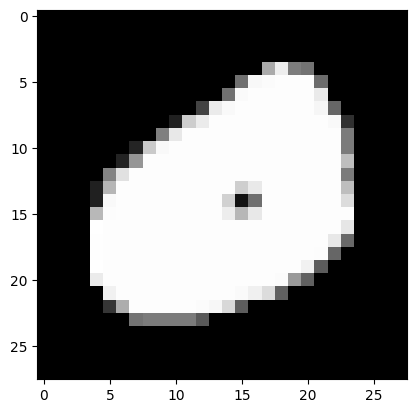

tensor(0)


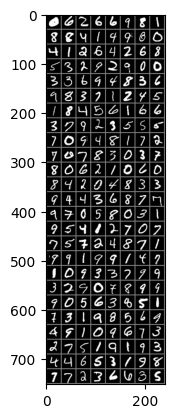

In [23]:
#matplot에서 imshow는 numpy형태를 요구, 픽셀값이 [0,1]값을 요구, 2D차원 요구
def imshow(img):
  img = (img+1)/2 #픽셀값 [-1,1] -> [0,1]변환
  img = img.squeeze() #3D차원 (D,H,W) -> 2D차원 (H,W)로 변환
  np_img = img.numpy() #tensor에서 numpy로 변환
  plt.imshow(np_img, cmap='gray')
  plt.show()

def imshow_grid(img):
  img = utils.make_grid(img.cpu().detach())
  img = (img+1)/2
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1,2,0)))
  plt.show()

#실제 이미지를 불러온 것. 
example_mini_batch_img, example_mini_batch_label = next(iter(train_data_loader))
imshow(example_mini_batch_img[0])
print(example_mini_batch_label[0])
imshow_grid(example_mini_batch_img)

In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import Transformer

class TransformerGenerator(nn.Module):
    def __init__(self, d_noise, d_model, nhead, num_encoder_layers, num_decoder_layers, dim_feedforward, dropout):
        super(TransformerGenerator, self).__init__()
        self.d_model = d_model
        self.embedding = nn.Linear(d_noise, d_model)
        self.transformer = Transformer(d_model, nhead, num_encoder_layers, num_decoder_layers, dim_feedforward, dropout)
        self.output_layer = nn.Linear(d_model, 28*28)
        self.tanh = nn.Tanh()
    
    def forward(self, z):
        z = self.embedding(z)
        z = z.unsqueeze(0)  # Add batch dimension
        transformer_out = self.transformer(z, z)
        transformer_out = transformer_out.squeeze(0)  # Remove batch dimension
        img = self.output_layer(transformer_out)
        img = self.tanh(img)
        img = img.view(-1, 1, 28, 28)
        return img

class TransformerDiscriminator(nn.Module):
    def __init__(self, d_model, nhead, num_encoder_layers,num_decoder_layers, dim_feedforward, dropout):
        super(TransformerDiscriminator, self).__init__()
        self.d_model = d_model
        self.embedding = nn.Linear(28*28, d_model)
        self.transformer = Transformer(d_model, nhead, num_encoder_layers, num_decoder_layers, dim_feedforward, dropout)
        self.output_layer = nn.Linear(d_model, 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        img_emb = self.embedding(img_flat)
        img_emb = img_emb.unsqueeze(0)  # Add batch dimension
        transformer_out = self.transformer(img_emb, img_emb)
        transformer_out = transformer_out.squeeze(0)  # Remove batch dimension
        validity = self.output_layer(transformer_out)
        validity = self.sigmoid(validity)
        return validity


def sample_z(batch_size = 1, d_noise=100):
    return torch.randn(batch_size, d_noise, device=device)

c:\Users\ksmin\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


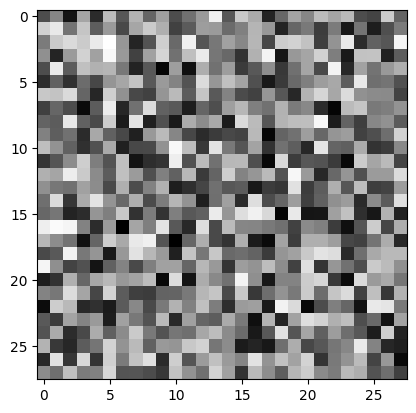

torch.Size([1, 1, 28, 28])
torch.Size([1, 1])
tensor([[0.6950]], grad_fn=<TransposeBackward0>)


In [25]:
# Hyperparameters
d_noise = 100
d_model = 256 #논문에서는 512차원
nhead = 8 #Q,K,V vector 256 / 8 = 32차원으로 축소, multihead attention 8번
num_encoder_layers = 6
num_decoder_layers = 6
dim_feedforward = 512
dropout = 0.1

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize models
G = TransformerGenerator(d_noise, d_model, nhead, num_encoder_layers, num_decoder_layers, dim_feedforward, dropout).to(device)
D = TransformerDiscriminator(d_model, nhead, num_encoder_layers, num_decoder_layers,dim_feedforward, dropout).to(device)

# Optimizers
optimizer_G = optim.Adam(G.parameters(), lr=0.0002)
optimizer_D = optim.Adam(D.parameters(), lr=0.0002)

# Loss function
adversarial_loss = nn.BCELoss()

z = sample_z()
img_fake = G(z).view(-1,28,28)
#이미지 출력
imshow(img_fake.squeeze().cpu().detach())

print(G(z).shape) #generator가 만든 이미지의 크기.
print(D(G(z)).shape) #discriminator의 출력값, 한 개의 이미지에 대해 한 개의 scalar값이다. 
print(D(G(z)[0]).transpose(0,1)) #진짜 이미지일 확률 0.5917 discriminator가 판단.  

In [26]:
def run_epoch(generator, discriminator, _optimizer_g, _optimizer_d):
    generator.train()
    discriminator.train()

    for img_batch, label_batch in train_data_loader:
        img_batch, label_batch = img_batch.to(device), label_batch.to(device)

        #init optimizer Discriminator
        _optimizer_d.zero_grad()

        p_real = discriminator(img_batch.view(-1,28*28)) #실제 이미지를 batch size만큼, discriminator에게 확인
        p_fake = discriminator(generator(sample_z(batch_size,d_noise))) #generator는 batch만큼 이미지를 만든다.

        loss_real = -1 * torch.log(p_real) # -1 for gradient ascending
        loss_fake = -1 * torch.log(1.-p_fake) # -1 for gradient ascending
        loss_d = (loss_real + loss_fake).mean()

        loss_d.backward()
        _optimizer_d.step()

        # init optimizer Gemerator
        _optimizer_g.zero_grad()

        p_fake = discriminator(generator(sample_z(batch_size,d_noise))) #batch만큼 만들어진 이미지에 discriminator는 확률값을 결정
        
        loss_g = -1 * torch.log(p_fake).mean() #loss는 평균값으로 계산

        loss_g.backward()

        _optimizer_g.step()

def evaluate_model(generator, discriminator):

    p_real, p_fake = 0.,0.

    generator.eval()
    discriminator.eval()

    for img_batch, label_batch in test_data_loader:

        img_batch, label_batch = img_batch.to(device), label_batch.to(device)

        with torch.autograd.no_grad():
            p_real += (torch.sum(discriminator(img_batch.view(-1, 28*28))).item())/10000.
            p_fake += (torch.sum(discriminator(generator(sample_z(batch_size, d_noise)))).item())/10000.


    return p_real, p_fake

In [27]:
#모델의 파라미터를 순회하면서 차원을 맞춰 오류를 해결해주는 역할 = 모델 초기화
def init_params(model):
    for p in model.parameters():
        if(p.dim() > 1):
            nn.init.xavier_normal_(p)
        else:
            nn.init.uniform_(p, 0.1, 0.2)

init_params(G)
init_params(D)

p_real_trace = []
p_fake_trace = []

for epoch in range(200):
    run_epoch(G,D,optimizer_G,optimizer_D)
    p_real, p_fake = evaluate_model(G,D)

    p_real_trace.append(p_real)
    p_fake_trace.append(p_fake)

    if((epoch+1)%1 == 0):
        print(f"Epoch {epoch}/{epoch} - p_real : {p_real}, p_fake : {p_fake}")
        imshow_grid(G(sample_z(16)).view(-1,1,28,28))

KeyboardInterrupt: 

In [ ]:
plt.plot(p_fake_trace, label='D(Generated)')
plt.plot(p_real_trace, label='D(real)')
plt.legend(bbox_to_anchor(1.05,1), loc = 2, borderaxespad=0.)
plt.xlabel("epoch")
plt.ylabel("Accuracy")
plt.show()